In [1]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing import sequence
from tqdm import tqdm

import os
import tempfile
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorboard import summary as summary_lib
import matplotlib.pyplot as plt
%matplotlib inline
tf.__version__

'1.7.0'

In [2]:
csv_file = "/Users/i337036/Downloads/train.csv"
df = pd.read_csv(csv_file, encoding='utf-8')
len(df)

404290

In [3]:
df.columns.values

array(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'],
      dtype=object)

In [4]:
# Remove cell later to train better
df = df.drop_duplicates(subset=['question1'], keep='first')
df = df.drop_duplicates(subset=['question2'], keep='first')
len(df)

252545

In [5]:
q1_list = df.question1.tolist()
q2_list = df.question2.tolist()
print(len(q1_list), len(q2_list))

252545 252545


In [6]:
q1q2_list = ["%s %s" % (txt1, txt2) for txt1, txt2 in zip(q1_list, q2_list)]
print(len(q1q2_list))

252545


In [7]:
labels = df["is_duplicate"].tolist()
print(len(labels))

252545


In [8]:
nb_words = 5000
tokenizer = Tokenizer(num_words=nb_words)

In [9]:
tokenizer.fit_on_texts(q1q2_list)
print(len(tokenizer.word_index))

90706


In [10]:
x_train_variable, y_train = [], []
x_test_variable, y_test = [], []
for idx in tqdm(range(len(q1q2_list))):
    if idx < 200000:
        x_train_variable.append(tokenizer.texts_to_sequences([q1q2_list[idx]])[0])
        y_train.append(labels[idx])
    else:
        x_test_variable.append(tokenizer.texts_to_sequences([q1q2_list[idx]])[0])
        y_test.append(labels[idx])

100%|██████████| 252545/252545 [00:05<00:00, 47425.08it/s]


In [11]:
vocab_size = 5000
sentence_size = 100
embedding_size = 50
model_dir = tempfile.mkdtemp()

y_train = np.array(y_train)
y_test = np.array(y_test)
# we assign the first indices in the vocabulary to special tokens that we use
# for padding, as start token, and for indicating unknown words
pad_id = 0

In [12]:
model_dir

'/var/folders/kb/fk2zcq9963b3wl7zqxx9d97w0000gn/T/tmp1lv94jn2'

In [13]:
print("Pad sequences (samples x time)")
x_train = sequence.pad_sequences(x_train_variable, maxlen=sentence_size, truncating='post', padding='post', value=pad_id)
x_test = sequence.pad_sequences(x_test_variable, maxlen=sentence_size, truncating='post', padding='post', value=pad_id)

Pad sequences (samples x time)


In [14]:
word_index = tokenizer.word_index
word_inverted_index = {v: k for k, v in word_index.items()}

In [15]:
word_inverted_index[pad_id] = '<PAD>'
for i in range(0, 10):
    print(i, word_inverted_index[i])

def index_to_text(indexes):
    return ' '.join([word_inverted_index[i] for i in indexes])

print(index_to_text(x_train_variable[0]))

0 <PAD>
1 the
2 what
3 is
4 a
5 i
6 to
7 in
8 how
9 of
what is the step by step guide to invest in share market in india what is the step by step guide to invest in share market


In [16]:
x_len_train = np.array([min(len(x), sentence_size) for x in x_train_variable])
x_len_test = np.array([min(len(x), sentence_size) for x in x_test_variable])

def parser(x, length, y):
    features = {"x": x, "len": length}
    return features, y

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x_train, x_len_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(x_train_variable))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser)
    dataset = dataset.repeat()
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

def eval_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x_test, x_len_test, y_test))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser)
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

In [17]:
column = tf.feature_column.categorical_column_with_identity('x', vocab_size)
classifier = tf.estimator.LinearClassifier(feature_columns=[column], model_dir=os.path.join(model_dir, 'bow_sparse'))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_save_checkpoints_secs': 600, '_num_worker_replicas': 1, '_tf_random_seed': None, '_global_id_in_cluster': 0, '_master': '', '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_log_step_count_steps': 100, '_session_config': None, '_is_chief': True, '_task_type': 'worker', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1837985e48>, '_model_dir': '/var/folders/kb/fk2zcq9963b3wl7zqxx9d97w0000gn/T/tmp1lv94jn2/bow_sparse', '_evaluation_master': '', '_save_checkpoints_steps': None, '_service': None, '_save_summary_steps': 100, '_task_id': 0}


In [18]:
all_classifiers = {}
def train_and_evaluate(classifier):
    # Save a reference to the classifier to run predictions later
    all_classifiers[classifier.model_dir] = classifier
    classifier.train(input_fn=train_input_fn, steps=25000)
    eval_results = classifier.evaluate(input_fn=eval_input_fn)
    predictions = np.array([p['logistic'][0] for p in classifier.predict(input_fn=eval_input_fn)])
        
    # Reset the graph to be able to reuse name scopes
    tf.reset_default_graph() 
    # Add a PR summary in addition to the summaries that the classifier writes
    pr = summary_lib.pr_curve('precision_recall', predictions=predictions, labels=y_test.astype(bool), num_thresholds=21)
    with tf.Session() as sess:
        writer = tf.summary.FileWriter(os.path.join(classifier.model_dir, 'eval'), sess.graph)
        writer.add_summary(sess.run(pr), global_step=0)
        writer.close()

In [19]:
train_and_evaluate(classifier)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/kb/fk2zcq9963b3wl7zqxx9d97w0000gn/T/tmp1lv94jn2/bow_sparse/model.ckpt.
INFO:tensorflow:step = 1, loss = 69.31472
INFO:tensorflow:global_step/sec: 96.007
INFO:tensorflow:step = 101, loss = 61.97246 (1.043 sec)
INFO:tensorflow:global_step/sec: 507.918
INFO:tensorflow:step = 201, loss = 61.087273 (0.196 sec)
INFO:tensorflow:global_step/sec: 539.38
INFO:tensorflow:step = 301, loss = 58.511894 (0.185 sec)
INFO:tensorflow:global_step/sec: 540.412
INFO:tensorflow:step = 401, loss = 51.94213 (0.185 sec)
INFO:tensorflow:global_step/sec: 519.338
INFO:tensorflow:step = 501, loss = 57.64603 (0.192 sec)
INFO:tensorflow:global_step/sec: 495.449
INFO:tensorflow:step = 601, loss = 48.65 (0.202 sec)
INFO:tensorf

INFO:tensorflow:step = 8001, loss = 42.285366 (0.495 sec)
INFO:tensorflow:global_step/sec: 457.358
INFO:tensorflow:step = 8101, loss = 54.307827 (0.220 sec)
INFO:tensorflow:global_step/sec: 459.401
INFO:tensorflow:step = 8201, loss = 49.171818 (0.218 sec)
INFO:tensorflow:global_step/sec: 487.058
INFO:tensorflow:step = 8301, loss = 56.431034 (0.205 sec)
INFO:tensorflow:global_step/sec: 460.257
INFO:tensorflow:step = 8401, loss = 46.470276 (0.217 sec)
INFO:tensorflow:global_step/sec: 458.077
INFO:tensorflow:step = 8501, loss = 47.035732 (0.218 sec)
INFO:tensorflow:global_step/sec: 454.425
INFO:tensorflow:step = 8601, loss = 55.82896 (0.220 sec)
INFO:tensorflow:global_step/sec: 445.094
INFO:tensorflow:step = 8701, loss = 56.863503 (0.225 sec)
INFO:tensorflow:global_step/sec: 474.169
INFO:tensorflow:step = 8801, loss = 44.548676 (0.210 sec)
INFO:tensorflow:global_step/sec: 489.575
INFO:tensorflow:step = 8901, loss = 51.98942 (0.204 sec)
INFO:tensorflow:global_step/sec: 409.18
INFO:tensorfl

INFO:tensorflow:step = 16301, loss = 51.717144 (0.218 sec)
INFO:tensorflow:global_step/sec: 495.365
INFO:tensorflow:step = 16401, loss = 60.270924 (0.202 sec)
INFO:tensorflow:global_step/sec: 480.081
INFO:tensorflow:step = 16501, loss = 53.820217 (0.208 sec)
INFO:tensorflow:global_step/sec: 480.261
INFO:tensorflow:step = 16601, loss = 45.685364 (0.209 sec)
INFO:tensorflow:global_step/sec: 472.456
INFO:tensorflow:step = 16701, loss = 49.015007 (0.212 sec)
INFO:tensorflow:global_step/sec: 479.893
INFO:tensorflow:step = 16801, loss = 47.647343 (0.208 sec)
INFO:tensorflow:global_step/sec: 522.373
INFO:tensorflow:step = 16901, loss = 55.84548 (0.191 sec)
INFO:tensorflow:global_step/sec: 517.799
INFO:tensorflow:step = 17001, loss = 54.78476 (0.193 sec)
INFO:tensorflow:global_step/sec: 528.187
INFO:tensorflow:step = 17101, loss = 58.291748 (0.190 sec)
INFO:tensorflow:global_step/sec: 521.363
INFO:tensorflow:step = 17201, loss = 44.101288 (0.192 sec)
INFO:tensorflow:global_step/sec: 522.884
IN

INFO:tensorflow:step = 24501, loss = 44.863636 (0.199 sec)
INFO:tensorflow:global_step/sec: 467.906
INFO:tensorflow:step = 24601, loss = 59.919136 (0.214 sec)
INFO:tensorflow:global_step/sec: 481.923
INFO:tensorflow:step = 24701, loss = 46.74328 (0.207 sec)
INFO:tensorflow:global_step/sec: 489.648
INFO:tensorflow:step = 24801, loss = 59.981266 (0.205 sec)
INFO:tensorflow:global_step/sec: 472.834
INFO:tensorflow:step = 24901, loss = 60.119442 (0.211 sec)
INFO:tensorflow:Saving checkpoints for 25000 into /var/folders/kb/fk2zcq9963b3wl7zqxx9d97w0000gn/T/tmp1lv94jn2/bow_sparse/model.ckpt.
INFO:tensorflow:Loss for final step: 42.594383.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-24-19:18:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/kb/fk2zcq9963b3wl7zqxx9d97w0000gn/T/tmp1lv94jn2/bow_sparse/model.ckpt-25000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done 

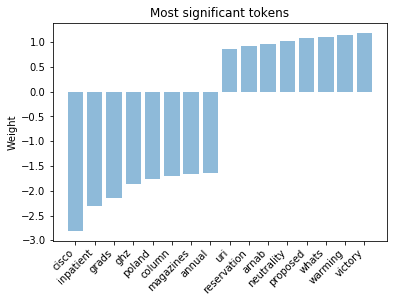

In [20]:
weights = classifier.get_variable_value('linear/linear_model/x/weights').flatten()
sorted_indexes = np.argsort(weights)
extremes = np.concatenate((sorted_indexes[-8:], sorted_indexes[:8]))
extreme_weights = sorted([(weights[i], word_inverted_index[i]) for i in extremes])

y_pos = np.arange(len(extreme_weights))
plt.bar(y_pos, [pair[0] for pair in extreme_weights], align='center', alpha=0.5)
plt.xticks(y_pos, [pair[1] for pair in extreme_weights], rotation=45, ha='right')
plt.ylabel('Weight')
plt.title('Most significant tokens') 
plt.show()

In [21]:
word_embedding_column = tf.feature_column.embedding_column(column, dimension=embedding_size)
classifier = tf.estimator.DNNClassifier(
    hidden_units=[100],
    feature_columns=[word_embedding_column], 
    model_dir=os.path.join(model_dir, 'bow_embeddings'))
train_and_evaluate(classifier)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_save_checkpoints_secs': 600, '_num_worker_replicas': 1, '_tf_random_seed': None, '_global_id_in_cluster': 0, '_master': '', '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_log_step_count_steps': 100, '_session_config': None, '_is_chief': True, '_task_type': 'worker', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x183db9ec50>, '_model_dir': '/var/folders/kb/fk2zcq9963b3wl7zqxx9d97w0000gn/T/tmp1lv94jn2/bow_embeddings', '_evaluation_master': '', '_save_checkpoints_steps': None, '_service': None, '_save_summary_steps': 100, '_task_id': 0}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/kb/fk2zcq9963b

INFO:tensorflow:step = 7301, loss = 49.937317 (0.239 sec)
INFO:tensorflow:global_step/sec: 416.24
INFO:tensorflow:step = 7401, loss = 54.96205 (0.240 sec)
INFO:tensorflow:global_step/sec: 413.003
INFO:tensorflow:step = 7501, loss = 47.26412 (0.242 sec)
INFO:tensorflow:global_step/sec: 411.262
INFO:tensorflow:step = 7601, loss = 53.711983 (0.243 sec)
INFO:tensorflow:global_step/sec: 406.744
INFO:tensorflow:step = 7701, loss = 56.485863 (0.246 sec)
INFO:tensorflow:global_step/sec: 400.938
INFO:tensorflow:step = 7801, loss = 52.13399 (0.249 sec)
INFO:tensorflow:global_step/sec: 395.732
INFO:tensorflow:step = 7901, loss = 53.673626 (0.253 sec)
INFO:tensorflow:global_step/sec: 205.795
INFO:tensorflow:step = 8001, loss = 43.125805 (0.486 sec)
INFO:tensorflow:global_step/sec: 424.102
INFO:tensorflow:step = 8101, loss = 43.838924 (0.236 sec)
INFO:tensorflow:global_step/sec: 426.269
INFO:tensorflow:step = 8201, loss = 56.663033 (0.234 sec)
INFO:tensorflow:global_step/sec: 427.473
INFO:tensorflo

INFO:tensorflow:step = 15601, loss = 41.8559 (0.277 sec)
INFO:tensorflow:global_step/sec: 356.042
INFO:tensorflow:step = 15701, loss = 50.544533 (0.281 sec)
INFO:tensorflow:global_step/sec: 370.343
INFO:tensorflow:step = 15801, loss = 53.863712 (0.270 sec)
INFO:tensorflow:global_step/sec: 361.487
INFO:tensorflow:step = 15901, loss = 50.674873 (0.277 sec)
INFO:tensorflow:global_step/sec: 183.862
INFO:tensorflow:step = 16001, loss = 45.30296 (0.544 sec)
INFO:tensorflow:global_step/sec: 370.714
INFO:tensorflow:step = 16101, loss = 54.729908 (0.270 sec)
INFO:tensorflow:global_step/sec: 378.026
INFO:tensorflow:step = 16201, loss = 45.945595 (0.264 sec)
INFO:tensorflow:global_step/sec: 358.96
INFO:tensorflow:step = 16301, loss = 44.202385 (0.278 sec)
INFO:tensorflow:global_step/sec: 386.512
INFO:tensorflow:step = 16401, loss = 41.024868 (0.259 sec)
INFO:tensorflow:global_step/sec: 407.44
INFO:tensorflow:step = 16501, loss = 50.02202 (0.246 sec)
INFO:tensorflow:global_step/sec: 366.027
INFO:t

INFO:tensorflow:global_step/sec: 378.625
INFO:tensorflow:step = 23901, loss = 43.204403 (0.264 sec)
INFO:tensorflow:global_step/sec: 197.355
INFO:tensorflow:step = 24001, loss = 43.925716 (0.507 sec)
INFO:tensorflow:global_step/sec: 404.934
INFO:tensorflow:step = 24101, loss = 41.84377 (0.247 sec)
INFO:tensorflow:global_step/sec: 426.181
INFO:tensorflow:step = 24201, loss = 41.53926 (0.235 sec)
INFO:tensorflow:global_step/sec: 409.893
INFO:tensorflow:step = 24301, loss = 54.74575 (0.244 sec)
INFO:tensorflow:global_step/sec: 414.95
INFO:tensorflow:step = 24401, loss = 46.63387 (0.241 sec)
INFO:tensorflow:global_step/sec: 401.515
INFO:tensorflow:step = 24501, loss = 39.22063 (0.249 sec)
INFO:tensorflow:global_step/sec: 384.506
INFO:tensorflow:step = 24601, loss = 41.7341 (0.260 sec)
INFO:tensorflow:global_step/sec: 400.244
INFO:tensorflow:step = 24701, loss = 47.265663 (0.250 sec)
INFO:tensorflow:global_step/sec: 399.79
INFO:tensorflow:step = 24801, loss = 39.838253 (0.250 sec)
INFO:tens

In [22]:
with open(os.path.join(model_dir, 'metadata.tsv'), 'w', encoding="utf-8") as f:
    f.write('label\n')
    for index in range(0, vocab_size):
        f.write(word_inverted_index[index] + '\n')

In [24]:
head = tf.contrib.estimator.binary_classification_head()

def cnn_model_fn(features, labels, mode, params):    
    input_layer = tf.contrib.layers.embed_sequence(
        features['x'], vocab_size, embedding_size,
        initializer=params['embedding_initializer'])
    
    training = mode == tf.estimator.ModeKeys.TRAIN
    dropout_emb = tf.layers.dropout(inputs=input_layer, 
                                    rate=0.2, 
                                    training=training)

    conv = tf.layers.conv1d(
        inputs=dropout_emb,
        filters=32,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    # Global Max Pooling
    pool = tf.reduce_max(input_tensor=conv, axis=1)
    
    hidden = tf.layers.dense(inputs=pool, units=250, activation=tf.nn.relu)
    
    dropout_hidden = tf.layers.dropout(inputs=hidden, 
                                       rate=0.2, 
                                       training=training)
    
    logits = tf.layers.dense(inputs=dropout_hidden, units=1)
    
    # This will be None when predicting
    if labels is not None:
        labels = tf.reshape(labels, [-1, 1])
        

    optimizer = tf.train.AdamOptimizer()
    
    def _train_op_fn(loss):
        return optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())

    return head.create_estimator_spec(
        features=features,
        labels=labels,
        mode=mode,
        logits=logits, 
        train_op_fn=_train_op_fn)
  
params = {'embedding_initializer': tf.random_uniform_initializer(-1.0, 1.0)}
cnn_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn,
                                        model_dir=os.path.join(model_dir, 'cnn'),
                                        params=params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_save_checkpoints_secs': 600, '_num_worker_replicas': 1, '_tf_random_seed': None, '_global_id_in_cluster': 0, '_master': '', '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_log_step_count_steps': 100, '_session_config': None, '_is_chief': True, '_task_type': 'worker', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x183dc4bc18>, '_model_dir': '/var/folders/kb/fk2zcq9963b3wl7zqxx9d97w0000gn/T/tmp1lv94jn2/cnn', '_evaluation_master': '', '_save_checkpoints_steps': None, '_service': None, '_save_summary_steps': 100, '_task_id': 0}


In [25]:
train_and_evaluate(cnn_classifier)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/kb/fk2zcq9963b3wl7zqxx9d97w0000gn/T/tmp1lv94jn2/cnn/model.ckpt.
INFO:tensorflow:step = 1, loss = 66.625336
INFO:tensorflow:global_step/sec: 35.6636
INFO:tensorflow:step = 101, loss = 55.480453 (2.805 sec)
INFO:tensorflow:global_step/sec: 53.7707
INFO:tensorflow:step = 201, loss = 51.601913 (1.860 sec)
INFO:tensorflow:global_step/sec: 53.6969
INFO:tensorflow:step = 301, loss = 65.52502 (1.862 sec)
INFO:tensorflow:global_step/sec: 53.3288
INFO:tensorflow:step = 401, loss = 59.284657 (1.875 sec)
INFO:tensorflow:global_step/sec: 54.1086
INFO:tensorflow:step = 501, loss = 54.30358 (1.849 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:global_step/sec: 49.0249
INFO:tensorflow:step = 7701, loss = 46.970055 (2.040 sec)
INFO:tensorflow:global_step/sec: 49.2426
INFO:tensorflow:step = 7801, loss = 40.26549 (2.031 sec)
INFO:tensorflow:global_step/sec: 47.2813
INFO:tensorflow:step = 7901, loss = 49.117886 (2.115 sec)
INFO:tensorflow:global_step/sec: 40.7164
INFO:tensorflow:step = 8001, loss = 49.35076 (2.456 sec)
INFO:tensorflow:global_step/sec: 54.7382
INFO:tensorflow:step = 8101, loss = 45.36584 (1.827 sec)
INFO:tensorflow:global_step/sec: 52.5645
INFO:tensorflow:step = 8201, loss = 45.96273 (1.902 sec)
INFO:tensorflow:global_step/sec: 52.7872
INFO:tensorflow:step = 8301, loss = 60.239162 (1.894 sec)
INFO:tensorflow:global_step/sec: 56.8564
INFO:tensorflow:step = 8401, loss = 51.77762 (1.759 sec)
INFO:tensorflow:global_step/sec: 49.7283
INFO:tensorflow:step = 8501, loss = 47.982437 (2.012 sec)
INFO:tensorflow:global_step/sec: 44.501
INFO:tensorflow:step = 8601, loss = 52.28705 (2.246 sec)
INFO:tensorflow:g

INFO:tensorflow:global_step/sec: 43.9707
INFO:tensorflow:step = 16001, loss = 49.778915 (2.274 sec)
INFO:tensorflow:global_step/sec: 49.7026
INFO:tensorflow:step = 16101, loss = 53.704567 (2.012 sec)
INFO:tensorflow:global_step/sec: 50.6707
INFO:tensorflow:step = 16201, loss = 42.248714 (1.973 sec)
INFO:tensorflow:global_step/sec: 50.8352
INFO:tensorflow:step = 16301, loss = 51.828907 (1.968 sec)
INFO:tensorflow:global_step/sec: 49.9768
INFO:tensorflow:step = 16401, loss = 41.724228 (2.000 sec)
INFO:tensorflow:global_step/sec: 49.9428
INFO:tensorflow:step = 16501, loss = 46.815346 (2.002 sec)
INFO:tensorflow:global_step/sec: 48.1318
INFO:tensorflow:step = 16601, loss = 46.739086 (2.078 sec)
INFO:tensorflow:global_step/sec: 43.62
INFO:tensorflow:step = 16701, loss = 59.58021 (2.293 sec)
INFO:tensorflow:global_step/sec: 44.6873
INFO:tensorflow:step = 16801, loss = 46.498962 (2.237 sec)
INFO:tensorflow:global_step/sec: 36.6444
INFO:tensorflow:step = 16901, loss = 46.748978 (2.730 sec)
INF

INFO:tensorflow:step = 24201, loss = 47.131268 (1.892 sec)
INFO:tensorflow:global_step/sec: 51.4224
INFO:tensorflow:step = 24301, loss = 36.58533 (1.945 sec)
INFO:tensorflow:global_step/sec: 52.808
INFO:tensorflow:step = 24401, loss = 36.466026 (1.893 sec)
INFO:tensorflow:global_step/sec: 53.1894
INFO:tensorflow:step = 24501, loss = 43.791058 (1.880 sec)
INFO:tensorflow:global_step/sec: 49.4164
INFO:tensorflow:step = 24601, loss = 40.706543 (2.023 sec)
INFO:tensorflow:global_step/sec: 49.2729
INFO:tensorflow:step = 24701, loss = 45.530884 (2.030 sec)
INFO:tensorflow:global_step/sec: 52.0477
INFO:tensorflow:step = 24801, loss = 53.018757 (1.921 sec)
INFO:tensorflow:global_step/sec: 46.0665
INFO:tensorflow:step = 24901, loss = 38.646404 (2.171 sec)
INFO:tensorflow:Saving checkpoints for 25000 into /var/folders/kb/fk2zcq9963b3wl7zqxx9d97w0000gn/T/tmp1lv94jn2/cnn/model.ckpt.
INFO:tensorflow:Loss for final step: 48.02839.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_